<a href="https://colab.research.google.com/github/kukuhpranata/modified-facenet/blob/main/yale21_25_NewModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 2.9MB/s 


In [ ]:
import mtcnn
# print version
print(mtcnn.__version__)

Using TensorFlow backend.


0.1.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd '/content/drive/My Drive/YaleDataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/YaleDataset


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # opencv
from mtcnn.mtcnn import MTCNN
from matplotlib import pyplot as plt
from keras.models import load_model
from PIL import Image

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/My Drive/YaleDataset"))

# Any results you write to the current directory are saved as output.

['yaleB23', 'yaleB25', 'yaleB22', 'yaleB21', 'yaleB24', 'model.png']


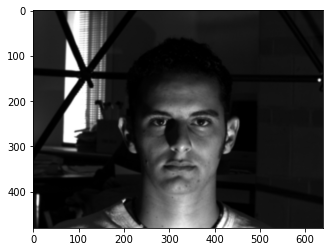

(480, 640, 3)


In [ ]:
img = cv2.imread('/content/drive/My Drive/YaleDataset/yaleB23/yaleB23_P00A-020E-40.pgm')
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
#plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()
print(img.shape)

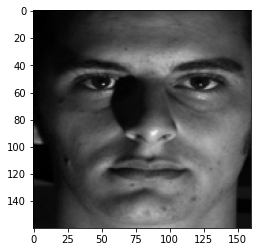

(160, 160, 3)


In [ ]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    # deal with negative pixel index
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

# load the photo and extract the face
pixels = extract_face('/content/drive/My Drive/YaleDataset/yaleB23/yaleB23_P00A-020E-40.pgm')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [ ]:
from sklearn.datasets import load_files
import numpy as np

data_dir = '/content/drive/My Drive/YaleDataset/'

def load_dataset(path):
    data = load_files(path) #load all files from the path
    files = np.array(data['filenames']) #get the file  
    targets = np.array(data['target'])#get the the classification labels as integer index
    target_labels = np.array(data['target_names'])#get the the classification labels 
    return files,targets,target_labels

x_data, y_data,target_labels = load_dataset(data_dir)
print('Dataset size : ' , x_data.shape[0])

Dataset size :  2965


In [ ]:
from sklearn.model_selection import train_test_split

x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)

print ("x_train shape: " + str(x_train.shape))
print ("x_train shape: " + str(y_train.shape))
print ("x_validate shape: " + str(x_validate.shape))
print ("y_validate shape: " + str(y_validate.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

x_train shape: (1660, 160, 160, 3)
x_train shape: (1660,)
x_validate shape: (415, 160, 160, 3)
y_validate shape: (415,)
x_test shape: (890,)
y_test shape: (890,)


In [ ]:
import cv2
print(cv2.__version__)



4.1.2


In [ ]:
def convert_image_to_array(files):
    width, height, channels = 160, 160, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) #define train and test data shape
    for idx,file in enumerate(files):
        try:
          img = cv2.imread(file) 
          res = cv2.resize(cv2.imread(file), dsize=(width, height), interpolation = cv2.INTER_AREA) #As images have different size, resizing all images to have same shape of image array
          images_as_array[idx] = res
        except Exception as e:
          print(str(e))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_validate))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

In [ ]:
#MEMBUAT MODEL
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K


def create_model():
  tmodel = Sequential([
    tf.keras.layers.Convolution2D(32, (3, 3), input_shape=(160,160,3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Convolution2D(32, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Convolution2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Convolution2D(64, 3, 3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Convolution2D(128, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Convolution2D(128, 3, 3),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('sigmoid'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('softmax')
  ])
  
  tmodel.compile(optimizer='adam',
                loss=tf.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  return tmodel


tmodel = create_model()


tmodel.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 158, 158, 32)      896       
_________________________________________________________________
activation_34 (Activation)   (None, 158, 158, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 156, 156, 32)      9248      
_________________________________________________________________
activation_35 (Activation)   (None, 156, 156, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 78, 78, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 78, 78, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 76, 76, 64)       

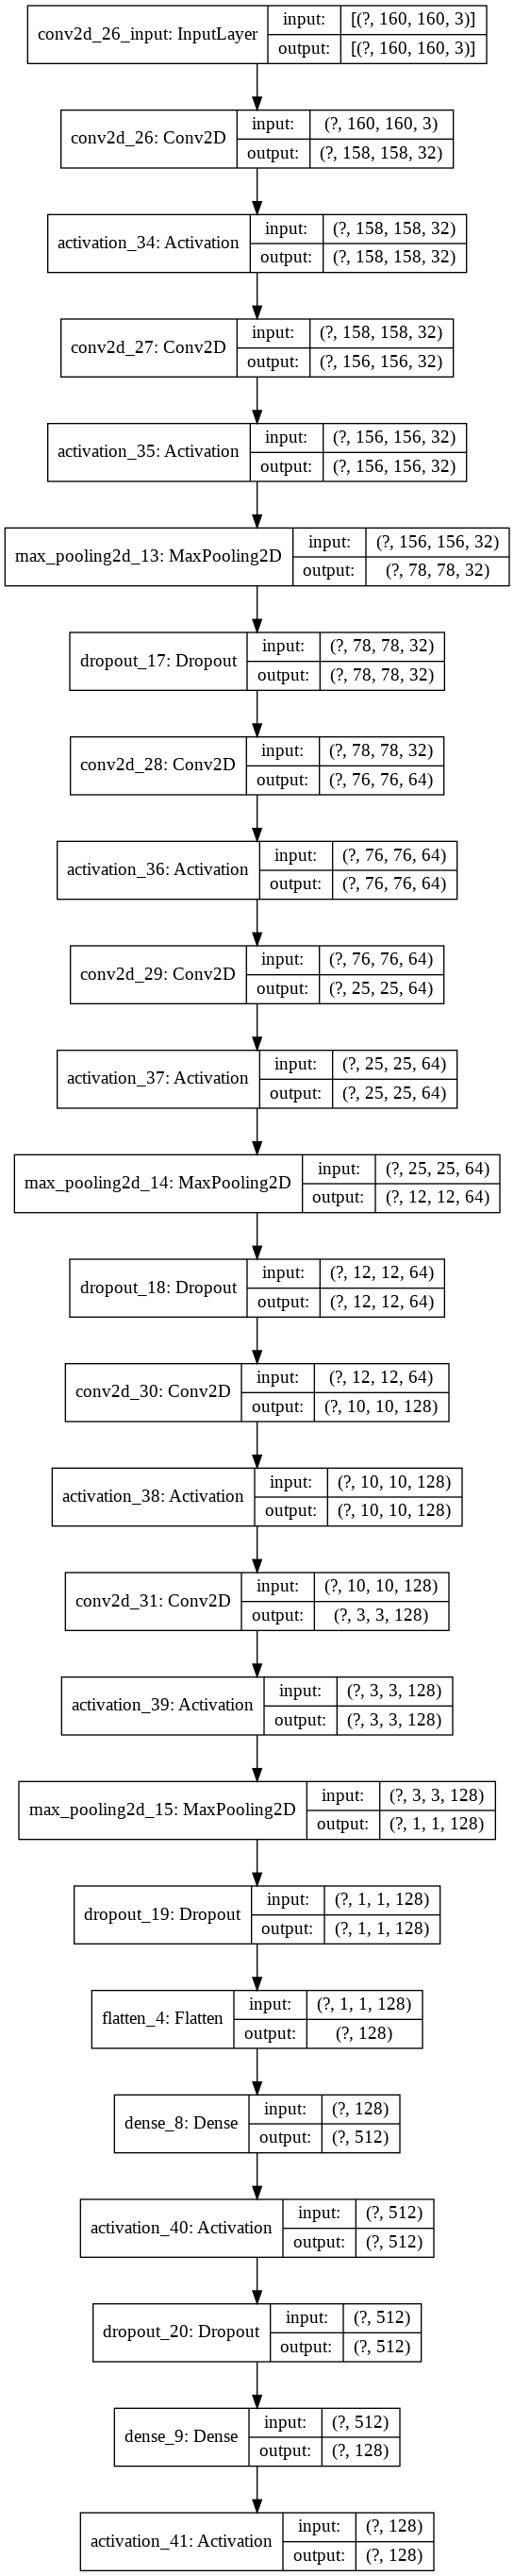

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(tmodel, to_file='model.png', show_shapes=True, expand_nested=False)

In [ ]:
def get_embedding(model, face):
    # scale pixel values
    face = face.astype('float32')
    # standardization
    mean, std = face.mean(), face.std()
    face = (face-mean)/std
    # transfer face into one sample (3 dimension to 4 dimension)
    sample = np.expand_dims(face, axis=0)
    # make prediction to get embedding
    yhat = model.predict(sample)
    return yhat[0]
    
# convert each face in the train set into embedding
emdTrainX = list()
for face in x_train:
    emd = get_embedding(tmodel, face)
    emdTrainX.append(emd)
    
emdTrainX = np.asarray(emdTrainX)
print(emdTrainX.shape)

# convert each face in the test set into embedding
emdTestX = list()
for face in x_test:
    emd = get_embedding(tmodel, face)
    emdTestX.append(emd)
emdTestX = np.asarray(emdTestX)
print(emdTestX.shape)

(1660, 128)
(890, 128)


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC

print("Dataset: train=%d, test=%d" % (emdTrainX.shape[0], emdTestX.shape[0]))
# normalize input vectors
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(emdTrainX)
emdTestX_norm = in_encoder.transform(emdTestX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
trainy_enc = out_encoder.transform(y_train)
testy_enc = out_encoder.transform(y_test)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_test = model.predict(emdTestX_norm)
# score
score_train = accuracy_score(trainy_enc, yhat_train)
score_test = accuracy_score(testy_enc, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Dataset: train=1660, test=890
Accuracy: train=20.663, test=20.225


Predicted: 
[0 1 2 3 4] 
[19.60134978 20.22526867 20.75044805 19.90968675 19.51324675]
Expected: 2


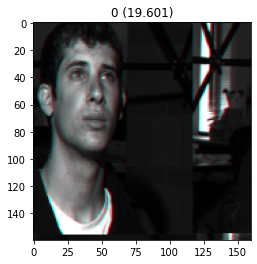

In [ ]:
from random import choice
# select a random face from test set
selection = choice([i for i in range(x_test.shape[0])])
random_face = x_test[selection]
random_face_emd = emdTestX_norm[selection]
random_face_class = testy_enc[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

# prediction for the face
samples = np.expand_dims(random_face_emd, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
all_names = out_encoder.inverse_transform([0,1,2,3,4])
#print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Predicted: \n%s \n%s' % (all_names, yhat_prob[0]*100))
print('Expected: %s' % random_face_name[0])
# plot face
plt.imshow(random_face)
title = '%s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
plt.show()